<a href="https://colab.research.google.com/github/sahar-mariam/kannada-sentiment-analysis/blob/main/m_BERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#!pip install transformers datasets

# importing necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# loading the dataset
file_path = "/content/balanced_dataset.csv"  # Upload your file to Colab
df = pd.read_csv(file_path)

# displaying dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3885 entries, 0 to 3884
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   textID             3885 non-null   object 
 1   text               3885 non-null   object 
 2   sentiment          3885 non-null   object 
 3   Time of Tweet      3885 non-null   object 
 4   Age of User        3885 non-null   object 
 5   Country            3885 non-null   object 
 6   Population -2020   3885 non-null   float64
 7   Land Area (Km²)    3885 non-null   float64
 8   Density (P/Km²)    3885 non-null   float64
 9   sentiment_numeric  3885 non-null   int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 303.6+ KB
None


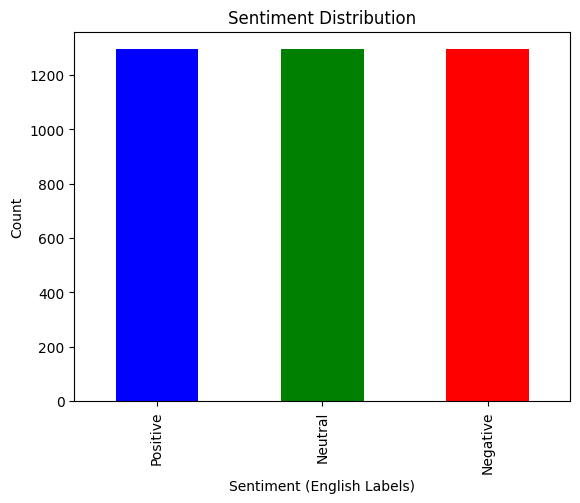

In [12]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

# Explicitly map sentiments to their desired order
sentiment_order = ['ಧನಾತ್ಮಕ', 'ತಟಸ್ಥ', 'ಋಣಾತ್ಮಕ']  # Positive, Neutral, Negative
colors = ['blue', 'green', 'red']  # Colors corresponding to sentiments

# Ensure the sentiment counts are in the correct order
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts = sentiment_counts.reindex(sentiment_order)

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (English Labels)')
plt.ylabel('Count')
plt.xticks(range(len(sentiment_order)), ['Positive', 'Neutral', 'Negative'])  # Add English labels to x-axis
plt.show()

In [13]:
# Data Preparation
# Preprocess the data for m-BERT
df['label'] = df['sentiment_numeric']  # Use numerical labels
df = df[['text', 'label']]  # Select relevant columns

# Split the data into train and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42
)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/3108 [00:00<?, ? examples/s]

Map:   0%|          | 0/777 [00:00<?, ? examples/s]

In [14]:
# Define the model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        "accuracy": (p.predictions.argmax(axis=1) == p.label_ids).mean()
    }
)

# Train the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.104700,0.989974,0.446589
2,0.789100,0.762315,0.667954
3,0.647300,0.770654,0.674389


TrainOutput(global_step=585, training_loss=0.8867439180357843, metrics={'train_runtime': 318.8691, 'train_samples_per_second': 29.241, 'train_steps_per_second': 1.835, 'total_flos': 613317376723968.0, 'train_loss': 0.8867439180357843, 'epoch': 3.0})

In [15]:
# Evaluate the model
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.7623152732849121, 'eval_accuracy': 0.667953667953668, 'eval_runtime': 5.3938, 'eval_samples_per_second': 144.055, 'eval_steps_per_second': 2.41, 'epoch': 3.0}


In [16]:
# Classification Report
val_predictions = trainer.predict(val_dataset)
val_preds = val_predictions.predictions.argmax(axis=-1)
print(classification_report(val_labels, val_preds, target_names=['Neutral', 'Positive', 'Negative']))

              precision    recall  f1-score   support

     Neutral       0.71      0.73      0.72       273
    Positive       0.54      0.53      0.54       230
    Negative       0.74      0.72      0.73       274

    accuracy                           0.67       777
   macro avg       0.66      0.66      0.66       777
weighted avg       0.67      0.67      0.67       777



In [19]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[199  54  20]
 [ 56 123  51]
 [ 26  51 197]]


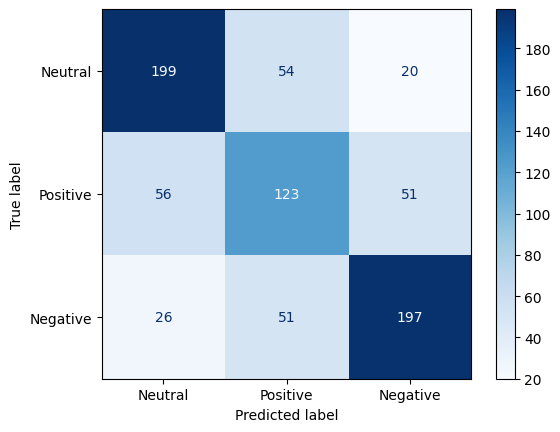

In [21]:
# Confusion Matrix Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [18]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to predict sentiment for user input
def predict_sentiment(user_input, model, tokenizer):
    # Tokenize the user input
    inputs = tokenizer(user_input, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Move input tensors to the correct device (GPU or CPU)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    # Sentiment mapping
    sentiment_map = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
    predicted_sentiment = sentiment_map[prediction]

    return predicted_sentiment

# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3).to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Example: Taking user input and predicting sentiment
user_input = input("Enter a sentence in Kannada: ")

# Predict sentiment
predicted_sentiment = predict_sentiment(user_input, model, tokenizer)
print(f"Predicted Sentiment: {predicted_sentiment}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Enter a sentence in Kannada: ಅವಳು ತನ್ನ ಹಣವನ್ನು ಕಳೆದುಕೊಂಡಳು
Predicted Sentiment: Negative
